In [15]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

from lib.asgnet.model import ASGNet
from dataset.semDataset import SemDataset
from lib.utils import *

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, RandomSampler
import cv2
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [10]:
train_transform = A.Compose([
                            ToTensorV2()
                            ])

train_dataset = SemDataset(data_dir_path="/opt/ml/input/data",
                           coco_list_path="/opt/ml/input/data/train.json",
                           data_type="train",
                           data_category=0,
                           transform=train_transform)
valid_dataset = SemDataset(data_dir_path="/opt/ml/input/data",
                           coco_list_path="/opt/ml/input/data/val.json",
                           data_type="val",
                           data_category=0,
                           transform=train_transform)
    
              

loading annotations into memory...
Done (t=3.75s)
creating index...
index created!
loading annotations into memory...
Done (t=1.47s)
creating index...
index created!


In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [50]:
train_loader = DataLoader(train_dataset, batch_size=6, sampler=RandomSampler(train_dataset), shuffle=False, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(valid_dataset, batch_size=6, sampler=RandomSampler(valid_dataset), shuffle=False, num_workers=4, collate_fn=collate_fn)

In [13]:
for main_imgs, main_masks, sub_imgs, sub_masks, seeds in train_loader:
    for main_img, main_mask, sub_img, sub_mask, seed in zip(main_imgs, main_masks, sub_imgs, sub_masks, seeds):
        m_img = main_img
        m_mask = main_mask
        s_img = sub_img
        s_mask = sub_mask
        break
    break 
print(m_img.shape)

torch.Size([3, 512, 512])


image shape: [3, 512, 512]
mask shape:  [512, 512]


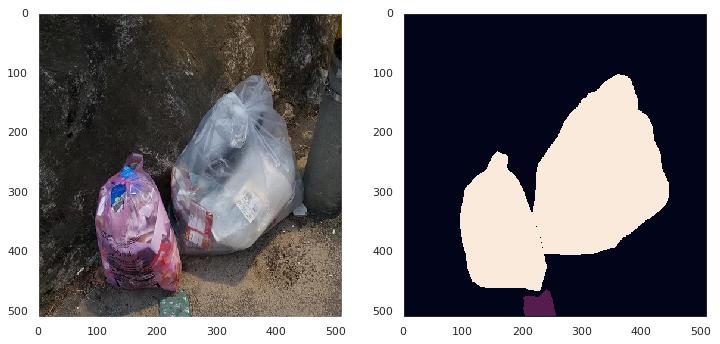

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(m_img.shape))
print('mask shape: ', list(m_mask.shape))

ax1.imshow(m_img.permute([1,2,0]))
ax1.grid(False)

ax2.imshow(m_mask)
ax2.grid(False)

image shape: [3, 512, 512]
mask shape:  [1, 512, 512]


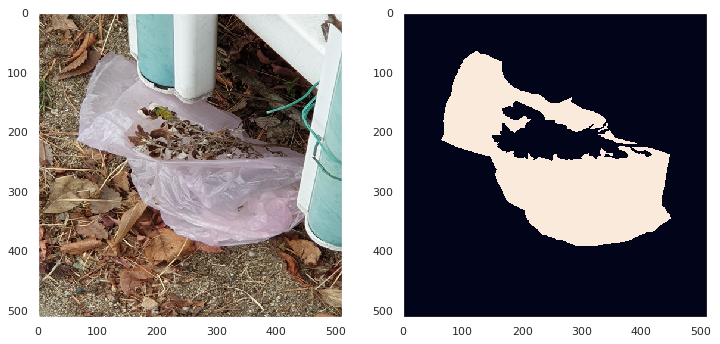

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(s_img.shape))
print('mask shape: ', list(s_mask.shape))
s_img = s_img.squeeze(0)
ax1.imshow(s_img.permute([1,2,0]))
ax1.grid(False)
s_mask = s_mask.squeeze(0)
ax2.imshow(s_mask)
ax2.grid(False)

In [20]:
num_epochs = 50
learning_rate = 0.0001

# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [51]:
model = ASGNet(layers = 50, classes = 12).cuda()

criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

INFO: Using ResNet 50


In [22]:
def save_model(model, saved_dir, file_name='hrnet_best_model(pretrained).pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

def show_class_mIoU(avrg_class_IoU):
    # Class Score
    class_name=['BG','UNK','General Trash','Paper','Paper pack','Metal','Glass','Plastic','Styrofoam','Plastic Bag','Battery','Clothing']
    print('-'*20)
    print('Validation Class Pred mIoU Score')
    for idx, class_score in enumerate(avrg_class_IoU):
        print('[{}] mIoU : [{:.4f}]'.format(class_name[idx],class_score))
    print('-'*20)

In [47]:
def validation(epoch, model, data_loader, criterion):
    print('Start validation #{}'.format(epoch))
    model.eval()
    hist = np.zeros((12, 12))

    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (main_images, main_masks, sub_images, sub_masks, seeds) in enumerate(data_loader):
            main_images = torch.stack(main_images).cuda()     # (batch, channel, height, width)
            main_masks = torch.stack(main_masks).long().cuda()  # (batch, channel, height, width)
            sub_images = torch.stack(sub_images).cuda()      # (batch, channel, height, width)
            sub_masks = torch.stack(sub_masks).long().cuda()  # (batch, channel, height, width)
            seeds = torch.stack(seeds).cuda()

            outputs = model(main_images, sub_images, sub_masks, seeds)
            loss = criterion(outputs, main_masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()

            mIoU = label_accuracy_score_ver1(main_masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
            hist = add_hist(hist, main_masks.detach().cpu().numpy(), outputs, n_class=12)

        mIoU, class_mIoU = label_accuracy_score_ver2(hist)    
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU1: {:.4f}, mIoU2: {:.4f}'.format(epoch, avrg_loss, np.mean(mIoU_list), mIoU))

    return avrg_loss, mIoU, class_mIoU

In [40]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, scheduler, saved_dir):
    print('Start training..')
    best_loss = 9999999
    best_miou = 0
    for epoch in range(num_epochs):
        model.train()
        for step, (main_images, main_masks, sub_images, sub_masks, seeds) in enumerate(data_loader):
            main_images = torch.stack(main_images).cuda()     # (batch, channel, height, width)
            main_masks = torch.stack(main_masks).long().cuda()  # (batch, channel, height, width)
            sub_images = torch.stack(sub_images).cuda()      # (batch, channel, height, width)
            sub_masks = torch.stack(sub_masks).long().cuda()  # (batch, channel, height, width)
            seeds = torch.stack(seeds).cuda()

            outputs = model(main_images, sub_images, sub_masks, seeds)

            loss = criterion(outputs, main_masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(loss) 

            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        if (epoch + 1) % 1 == 0:
            avrg_loss, miou, class_miou = validation(epoch + 1, model, val_loader, criterion)
            show_class_mIoU(class_miou)
            if avrg_loss < best_loss:
                print('Best performance at epoch(loss): {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir, file_name=f"asgnet_loss_best_at_epoch_{epoch+1}.pth")
            if miou > best_miou:
                print('Best performance at epoch(miou): {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_miou = miou
                save_model(model, saved_dir, file_name=f"asgnet_loss_best_at_epoch_{epoch+1}.pth")


In [49]:
train(50, model, train_loader, val_loader, criterion, optimizer, scheduler, "/opt/ml/pretrained")

Start training..
Epoch [1/50], Step [25/218], Loss: 1.1414
Epoch [1/50], Step [50/218], Loss: 1.3042
Epoch [1/50], Step [75/218], Loss: 1.2687
Epoch [1/50], Step [100/218], Loss: 0.8718


KeyboardInterrupt: 